# Read in data

In [1]:

import pandas as pd
import numpy as np
from itertools import product, combinations
from src.helpers import make_aesthetic
import random
random.seed(42)
np.random.seed(42)

def make_bold(x):
    words = x.split()
    words = ' \\ '.join([w for w in words])  # Escape backslash properly
    bold_str = f"$\\bf{{{words}}}$"  # Correctly format the f-string
    return bold_str


def read_data():
    df = pd.read_csv("../data/clean/ssl5.csv")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Proportion'] = pd.to_numeric(df['Proportion'], errors='coerce')
    df['Relavent_N'] = pd.to_numeric(df['Relavent_N'], errors='coerce')
    df['N'] = pd.to_numeric(df['N'], errors='coerce')
    df['Study'] = df['Title']
    df = df.dropna(subset=['Date', 'Proportion', 'N'])
    
    
    return df
    
df = read_data()
print(df['Proportion'].describe())

print(df)





count    19.000000
mean      0.310524
std       0.132178
min       0.130000
25%       0.230000
50%       0.290000
75%       0.370000
max       0.680000
Name: Proportion, dtype: float64
              Source                                               Kind  \
0   Consumer Reports                          Nationally representative   
1   Consumer Reports                          Nationally representative   
2   Consumer Reports                          Nationally representative   
3            Rutgers                          Nationally representative   
4               NBER               Nationally representative of workers   
5               NBER               Nationally representative of workers   
6    Elon University             Nationally representative of LLM users   
7    Elon University             Nationally representative of LLM users   
8    Elon University             Nationally representative of LLM users   
9    Elon University             Nationally representative of LLM

# Simulations

## Test Underlying Logic

In [3]:

def get_estimators():
    return {
        'sample_mean': lambda probs: np.mean(probs),
        'observed_max': lambda probs: np.max(probs),
        'second_largest': lambda probs: np.sort(probs)[::-1][1] if len(probs) > 1 else probs[0],
        'third_largest': lambda probs: np.sort(probs)[::-1][2] if len(probs) > 2 else np.sort(probs)[::-1][-1],
        'median': lambda probs: np.median(probs)
    }



def run_simulation_test(n_events=21, sample_size=10000, n_sims=10000):
    """Run simulation and return results"""
    np.random.seed(42)
    estimators = get_estimators()
    results = {name: [] for name in estimators.keys()}
    results['true_max'] = []
    
    for _ in range(n_sims):
        true_probs = np.random.beta(2, 2, n_events)
        
        assert len(true_probs) == n_events, "True probabilities length mismatch"
        assert np.all((true_probs >= 0) & (true_probs <= 1)), "True probabilities out of bounds"
        
        true_max = np.max(true_probs)
        assert 0 <= true_max <= 1, "True max out of bounds"
        
        
        binomial_realizations = np.random.binomial(sample_size, true_probs) 
        assert len(binomial_realizations) == n_events, "Binomial realizations length mismatch"
        assert np.all((binomial_realizations >= 0) & (binomial_realizations <= sample_size)), "Binomial realizations out of bounds"
        observed_probs = binomial_realizations / sample_size
        assert len(observed_probs) == n_events, "Observed probabilities length mismatch"
        
        results['true_max'].append(true_max)
        for name, estimator in estimators.items():
            results[name].append(estimator(observed_probs))
    
    return pd.DataFrame(results)

run_simulation_test()
print("We passed :)")

We passed :)


Running Order Statistics Simulation...


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_75551/3312905211.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(errors.values(), labels=errors.keys())
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_75551/3312905211.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


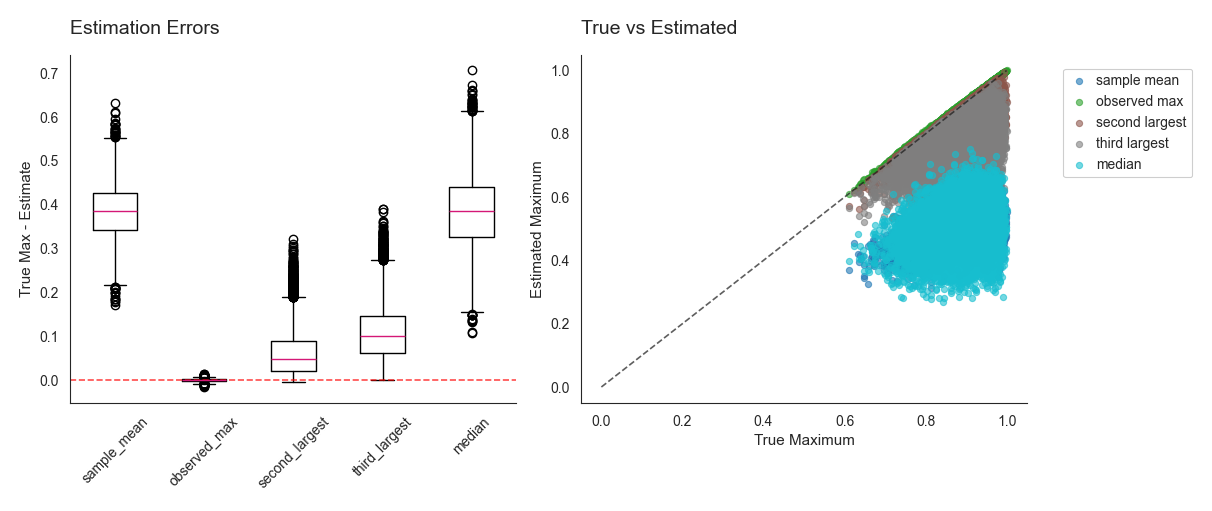

        Estimator      Bias      RMSE  Percent Too High  Percent Too Low
0     sample mean -0.384479  0.389446              0.00           100.00
1    observed max  0.000100  0.003161             51.14            48.86
2  second largest -0.061416  0.079665              0.85            99.15
3   third largest -0.109151  0.125614              0.01            99.99
4          median -0.384750  0.393679              0.00           100.00
0.4625


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

make_aesthetic(font_scale=1)


def clean_text(text):
    """Clean text for LaTeX compatibility"""
    return text.replace('_', " ")

def run_simulation(n_events=21, sample_size=10000, n_sims=10000):
    """Run simulation and return results"""
    np.random.seed(42)
    estimators = get_estimators()
    results = {name: [] for name in estimators.keys()}
    results['true_max'] = []
    
    for _ in range(n_sims):
        
        true_probs = np.random.beta(2, 2, n_events)
        true_max = np.max(true_probs)
        
        observed_probs = np.random.binomial(sample_size, true_probs) / sample_size
        
        results['true_max'].append(true_max)
        for name, estimator in estimators.items():
            results[name].append(estimator(observed_probs))
    
    return pd.DataFrame(results)

def analyze_results(df):
    estimators = [col for col in df.columns if col != 'true_max']
    results = []
    for est in estimators:
        bias = np.mean(df[est] - df['true_max'])
        rmse = np.sqrt(np.mean((df[est] - df['true_max'])**2))
        pct_too_high = (np.mean(df[est] > df['true_max']) )*100
        pct_too_low = (np.mean(df[est] < df['true_max']) )*100
        
        results.append({
            'Estimator': clean_text(est),
            'Bias': bias,
            'RMSE': rmse,
            'Percent Too High': pct_too_high,
            'Percent Too Low': pct_too_low
        })
    
    return pd.DataFrame(results)

def plot_results(df):
    """Simple visualization"""
    estimators = [col for col in df.columns if col != 'true_max']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    errors = {}
    for est in estimators:
        errors[est] = df['true_max'] - df[est]
    
    ax1.boxplot(errors.values(), labels=errors.keys())
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.set_ylabel('True Max - Estimate')
    ax1.set_title('Estimation Errors')
    ax1.tick_params(axis='x', rotation=45)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(estimators)))
    for i, est in enumerate(estimators):
        ax2.scatter(df['true_max'], df[est], alpha=0.6, 
                   label=clean_text(est), color=colors[i], s=20)
    
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.7)
    ax2.set_xlabel('True Maximum')
    ax2.set_ylabel('Estimated Maximum')
    ax2.set_title('True vs Estimated')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Run the simulation
print("Running Order Statistics Simulation...")
df = run_simulation()
sum_df = analyze_results(df)
plot_results(df)
print(sum_df)

sum_df.to_latex("../tables/estimation_methods.tex", index=False, escape=False, float_format="%.3f")


df = read_data()
raw_data = sorted(df['Proportion'].to_list())
print(raw_data[-2])



# Multiverse

In [5]:

import pandas as pd
import numpy as np
from itertools import product, combinations
# Compute weighted mean and std
def compute_weighted_mean(proportions, weights):
    avg = np.average(proportions, weights=weights)
    std = np.sqrt(np.average((proportions - avg)**2, weights=weights))
    return avg, std

# Weighting logic
def weight_updated(method, df_subset):
    if method == 'no_weighting':
        weights = np.ones(len(df_subset))
    elif method == 'sample_size':
        weights = df_subset['N']
    elif method in ['recency_fast_decay', 'recency_slow_decay']:
        end_date = pd.to_datetime("2025-06-01")

        # to explain logic here:
        # 1/e^(alpha*(date-max_date))
        # so when its max date we have 1/e^0 = 1 etc
        if method == 'recency_fast_decay':
            alpha = 0.1
        elif method == 'recency_slow_decay':
            alpha = 0.05
        weights = np.exp(-alpha * (end_date - df_subset['Date']).dt.days)
    else:
        raise ValueError(f"Unknown weighting method: {method}")
    return compute_weighted_mean(df_subset['Proportion'], weights)

# Survey-level averaging
def apply_survey_macro_averaging(df_subset):
    return df_subset.groupby('Title').agg({
        'N': "mean",
        'Proportion': 'mean',
        'Date': 'first'
    }).reset_index()

# Generate all combinations of rows to drop
def all_combinations(lst, subset_len):
    return [list(c) for c in combinations(lst, subset_len)]

# Main multiverse run
def run_multiverse(df):
    d1_options = [False, True]
    d2_options = ['no_weighting', 'sample_size', 'recency_fast_decay', 'recency_slow_decay']
    multiverse_results = []
    for d1, d2 in product(d1_options, d2_options):
        try:
            df_subset = apply_survey_macro_averaging(df) if d1 else df.copy()
            mean, sd = weight_updated(d2, df_subset)
            multiverse_results.append({
                'survey_avg': 'macro' if d1 else 'raw',
                'question_weighting': d2,
                'Mean': mean,
                'SD': sd
            })
        except Exception as e:
            multiverse_results.append({
                'survey_avg': 'macro' if d1 else 'raw',
                'question_weighting': d2,
                'Mean': None,
                'SD': None,
                'Error': str(e)
            })
    return pd.DataFrame(multiverse_results)

# Initial multiverse
df = read_data()
multiverse_df = run_multiverse(df)
multiverse_df['dropped'] = 'none'
multiverse_df['did_drop'] = "no_dropping"

# Drop-2 analyses
rows = range(len(df))
all_combos = list(combinations(rows, 2))
dropped_dfs = []
for combo in all_combos:
    temp_df = df.drop(index=list(combo)).reset_index(drop=True)
    temp_multiverse = run_multiverse(temp_df)
    temp_multiverse['dropped'] = str(combo)
    temp_multiverse["did_drop"] = "leave_2_out"
    dropped_dfs.append(temp_multiverse)

drop_df = pd.concat(dropped_dfs, ignore_index=True)
full_data = pd.concat([multiverse_df, drop_df], ignore_index=True)

# Summary
total_responses = df['N'].sum() 
total_n = df.groupby(by=['Title'])['N'].mean().reset_index()['N'].sum()
means = full_data['Mean'].dropna().to_list()
desc_str = f"{int(total_n):,} Participants, {int(total_responses):,} Responses, {len(means):,} analyses"
print(desc_str)

16,657 Participants, 30,510 Responses, 1,376 analyses


# Histogram plot

16,657 Participants, 30,510 Responses, 1,376 analyses
mean 0.32
iqr [0.31-0.34]
ci [0.26-0.37]


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_75551/1959188570.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


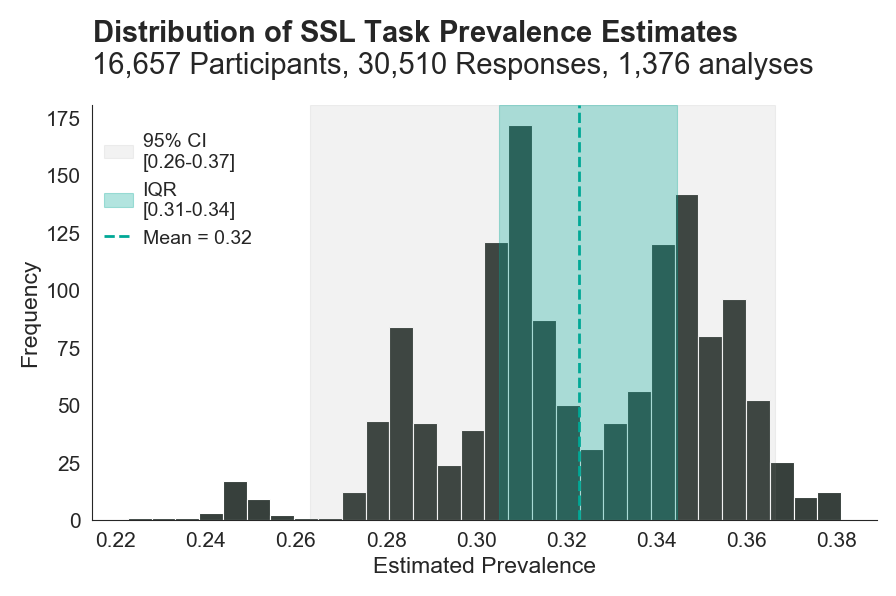

In [6]:
# Re-import required modules after code execution reset
print(desc_str)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

make_aesthetic(font_scale=1.5)


mypal = [
    "#2C3531", "#D41876", "#00A896", "#826AED", "#F45B69",
    "#E3B505", "#89DAFF", "#342E37", "#7DCD85", "#F7B2AD",
    "#D4B2D8", "#020887", "#E87461", "#7E6551", "#F18805"
]



mean_val = np.mean(means)
q25, q75 = np.percentile(means, [25, 75])
lower, upper = np.percentile(means, [2.5, 97.5])

iqr = f"[{q25:.2f}-{q75:.2f}]"  
ci = f"[{lower:.2f}-{upper:.2f}]"  

print("mean", f"{mean_val:.2f}")
print("iqr", iqr)
print("ci", ci)

# Aesthetic plot
plt.figure(figsize=(9, 6))

# basic histplot
sns.histplot(means, bins=30, kde=False, color=mypal[0], edgecolor="white", alpha=0.95)


# ci
plt.axvspan(lower, upper, color='gray', alpha=0.1, label=f"95% CI\n{ci}")

# iqr
plt.axvspan(q25, q75, color=mypal[2], alpha=0.3, label=f"IQR\n{iqr}")

# mean line
plt.axvline(mean_val, color=mypal[2], linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")


# labels
plt.title(f"{make_bold("Distribution of SSL Task Prevalence Estimates")}\n{desc_str}")
plt.xlabel("Estimated Prevalence")
plt.ylabel("Frequency")
plt.legend(frameon=False, fontsize=14, loc="upper left", bbox_to_anchor=(-0.02, 1))
sns.despine()
plt.tight_layout()
plt.savefig("../plots/prev_hist.pdf", dpi=300, bbox_inches='tight')


plt.show()


# Sensitivity analysis

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_75551/1656787171.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


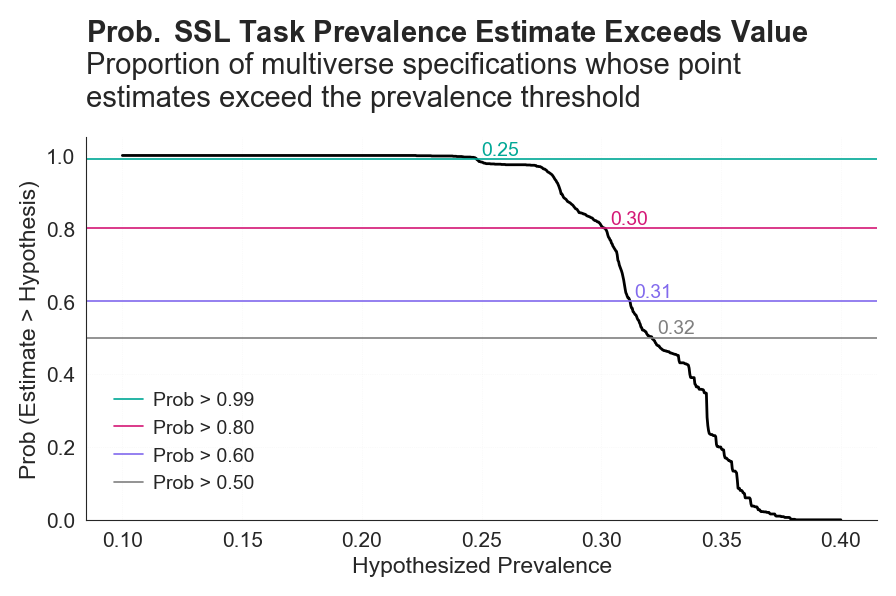

In [7]:
import numpy as np
import matplotlib.pyplot as plt

posterior_samples = np.array(means)
null_values = np.linspace(0.10, 0.40, 1000)
probs = [(posterior_samples > null).mean() for null in null_values]

plt.figure(figsize=(9, 6))
plt.plot(null_values, probs, color='black', lw=2)

threshold_specs = [
    (0.99, mypal[2], "Prob > 0.99"),
    (0.80, mypal[1], "Prob > 0.80"),
    (0.60, mypal[3], "Prob > 0.60"),
    (0.50, "gray",   "Prob > 0.50"),
]

for thresh, col, lbl in threshold_specs:
    # draw the horizontal line
    plt.axhline(thresh, linestyle='-', color=col, label=lbl)

    idxs = np.where(np.array(probs) >= thresh)[0]
    if len(idxs):                      
        x_star = null_values[idxs[-1]]  
        plt.text(x_star + 0.01, thresh, f"{x_star:.2f}",
                 color=col, ha='center', va='bottom', fontsize=14)
# ---------------------------------------------------------------------------


plt.xlabel("Hypothesized Prevalence")
plt.ylabel("Prob (Estimate > Hypothesis)")
plt.title(
    f"{make_bold('Prob. SSL Task Prevalence Estimate Exceeds Value')}\n"
    "Proportion of multiverse specifications whose point\nestimates exceed the "
    "prevalence threshold"
)
plt.legend(frameon=False, fontsize=14, loc="lower left")
plt.grid(alpha=0.2)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("../plots/prev_sensitivity.pdf", dpi=300, bbox_inches='tight')

plt.show()


In [8]:
probs

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

# Predictors of estimates in multiverse

/Users/joshash/locresearch/LocResearch/ssl_wrapper/proj/ssl/src/statsmodels_handler.py:85: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sum_res = pd.read_html(self.model.summary().tables[1].as_html(), header=0, index_col=0)[0].reset_index()
/Users/joshash/locresearch/LocResearch/ssl_wrapper/proj/ssl/src/statsmodels_handler.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.pointplot(y='var', x='coef', data=sum_res, capsize=0.1,


$\bf{Regression \ Coefficients \ of \ How \ Analysis \ Choices \ Affect \ Estimated \ Prevalence}$
The baseline is raw data, no weighting, and no dropping.
Intercept: $\beta = 30.69$, $SE = 0.61$, $p <0.001$, $95\% CI = [29.49, 31.89]$
C(question\_weighting, Treatment(reference="no\_weighting"))[T.recency\_fast\_decay]: $\beta = 3.64$, $SE = 0.13$, $p <0.001$, $95\% CI = [3.39, 3.90]$
C(question\_weighting, Treatment(reference="no\_weighting"))[T.recency\_slow\_decay]: $\beta = 3.83$, $SE = 0.13$, $p <0.001$, $95\% CI = [3.57, 4.08]$
C(question\_weighting, Treatment(reference="no\_weighting"))[T.sample\_size]: $\beta = -1.42$, $SE = 0.13$, $p <0.001$, $95\% CI = [-1.67, -1.16]$
C(survey\_avg, Treatment(reference="raw"))[T.macro]: $\beta = 0.40$, $SE = 0.09$, $p <0.001$, $95\% CI = [0.22, 0.58]$
C(did\_drop, Treatment(reference="no\_dropping"))[T.leave\_2\_out]: $\beta = -0.13$, $SE = 0.61$, $p = 0.827$, $95\% CI = [-1.32, 1.06]$


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Mean100   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     493.9
Date:                Wed, 18 Jun 2025   Prob (F-statistic):          1.91e-303
Time:                        21:10:51   Log-Likelihood:                -2686.1
No. Observations:                1376   AIC:                             5384.
Df Residuals:                    1370   BIC:                             5416.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================================
                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                           30.6916      0.611     50.241      0.000      29.493      31.890
C(question_weighting, Treatment(reference="no_weighting"))[T.recency_fast_decay]     3.6446      0.130     27.984      0.000       3.389       3.900
C(question_weighting, Treatment(reference="no_weighting"))[T.recency_slow_decay]     3.8271      0.130     29.385      0.000       3.572       4.083
C(question_weighting, Treatment(reference="no_weighting"))[T.sample_size]           -1.4183      0.130    -10.890      0.000      -1.674      -1.163
C(survey_avg, Treatment(reference="raw"))[T.macro]                                   0.4034      0.092      4.380      0.000       0.223       0.584
C(did_drop, Treatment(reference="no_dropping"))[T.leave_2_out]                      -0.1320      0.606     -0.218      0.827      -1.320       1.056
==============================================================================
Omnibus:                      143.413   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.702
Skew:                          -0.698   Prob(JB):                     2.21e-55
Kurtosis:                       4.563   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

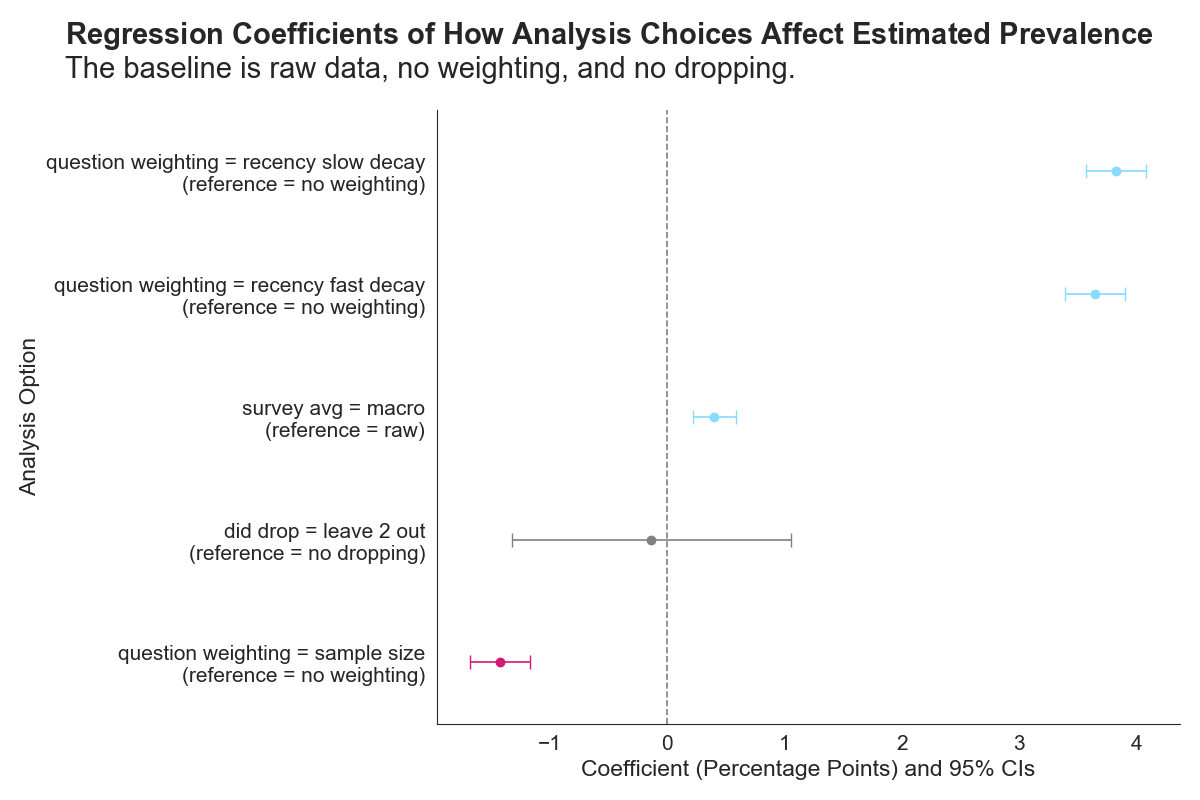

In [9]:
import statsmodels.formula.api as smf
from src.statsmodels_handler import StatsmodelsHandler, clean_var_name_from_formula

make_aesthetic(font_scale=1.5)
    
full_data['Mean100'] = full_data['Mean']*100
mod = smf.ols(formula='Mean100 ~ C(question_weighting, Treatment(reference="no_weighting")) + C(survey_avg, Treatment(reference="raw")) + '
                      'C(did_drop, Treatment(reference="no_dropping"))', data=full_data).fit()

handler = StatsmodelsHandler(model=mod)
ax = handler.plot(figsize=(12,8), clean_var_name = clean_var_name_from_formula)
plt.xlabel("Coefficient (Percentage Points) and 95% CIs")
plt.ylabel("Analysis Option")

full_title = f"{make_bold("Regression Coefficients of How Analysis Choices Affect Estimated Prevalence")}\nThe baseline is raw data, no weighting, and no dropping."
print(full_title)

plt.title(full_title, x=-0.5)
plt.savefig("../plots/prev_multiverse_regression.pdf", dpi=300, bbox_inches='tight')


handler.to_latex()

display(mod.summary())



In [10]:
# make sure we are getting back actual raw estimate
raw_con_from_multi = full_data.query("survey_avg == 'raw' and question_weighting == 'no_weighting' and did_drop == 'no_dropping'")['Mean'].mean()
raw_con_from_raw = df['Proportion'].mean()
assert raw_con_from_multi == raw_con_from_raw, "Raw control from multiverse does not match raw data mean!"


# Raw data analysis

Text(0.0, 1.0, 'Raw Estimates by Year and Sample Size')

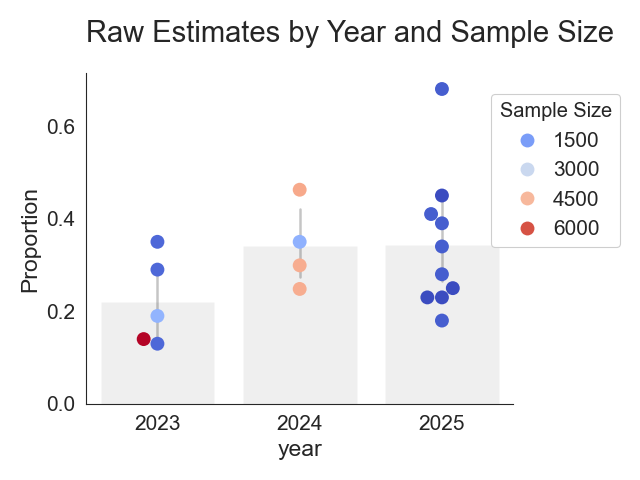

In [11]:
df['year'] = df['Date'].dt.year
sns.swarmplot(x='year', y='Proportion', data=df, palette="coolwarm", hue='N', s=10)
sns.barplot(x='year', y='Proportion', data=df, color='gray', alpha=0.12, err_kws={'alpha':0.3})
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', title='Sample Size')
plt.title("Raw Estimates by Year and Sample Size")




# cis

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_75551/691240881.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


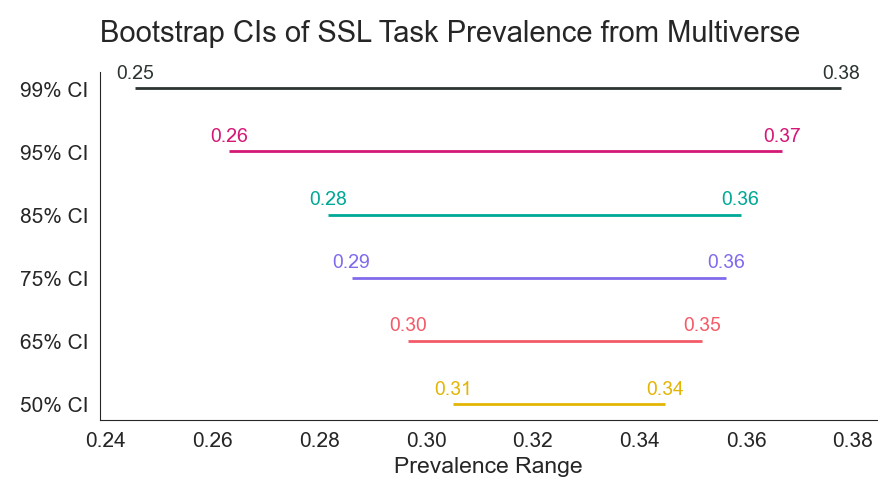

In [12]:
import numpy as np
import matplotlib.pyplot as plt


make_aesthetic(font_scale=1.5)

def bootstrap_ci(data, n_iterations=1000, ci=0.95):
    """Compute bootstrap confidence intervals."""
    n = len(data)
    indices = np.random.randint(0, n, (n_iterations, n))
    samples = data[indices]
    lower = np.percentile(samples, (1 - ci) / 2 * 100, axis=1)
    upper = np.percentile(samples, (1 + ci) / 2 * 100, axis=1)
    return np.mean(lower), np.mean(upper)

samples = np.array(means)
bootstrap_probs = [0.99, 0.95, 0.85, 0.75, 0.65, 0.50]
bootstrap_intervals = [bootstrap_ci(samples, n_iterations=1000, ci=prob) for prob in bootstrap_probs]
y_positions = list(range(len(bootstrap_probs), 0, -1))

plt.figure(figsize=(9, 5))

for i, (ci, prob) in enumerate(zip(bootstrap_intervals, bootstrap_probs)):
    plt.hlines(y_positions[i], ci[0], ci[1], color=mypal[i % len(mypal)], linewidth=2, label=f"{int(prob * 100)}% CI")
    plt.text(ci[0], y_positions[i] + 0.1, f"{ci[0]:.2f}", ha='center', va='bottom', fontsize=14, color=mypal[i % len(mypal)])
    plt.text(ci[1], y_positions[i] + 0.1, f"{ci[1]:.2f}", ha='center', va='bottom', fontsize=14, color=mypal[i % len(mypal)])

# Add labels and aesthetics
plt.xlabel("Prevalence Range")
plt.yticks(y_positions, [f"{int(prob * 100)}% CI" for prob in bootstrap_probs])  # Label y-axis positions
plt.title(f"Bootstrap CIs of SSL Task Prevalence from Multiverse")
plt.tight_layout()
plt.savefig("../plots/prev_bootstrap_ci.pdf", dpi=300, bbox_inches='tight')
plt.show()

0.9979857628356986